## Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy.stats as stats
from sklearn.model_selection import train_test_split

### Plusieurs fois la simulation

In [22]:
def power_simulation(n, m, num_simulations=1000):

    np.random.seed(42)
    power = []
    esperances = []
    variances = []
    test_statistics = []
    test_alternative = []
    beta1 = 2
    beta2_values = np.linspace(0, 0.16, 9)
    delta_list = []

    for beta2 in beta2_values:

        differences = []

        for _ in range(num_simulations):
            epsilon = np.random.normal(0, 1, n + m)  # Generate epsilon inside the loop
            x = np.random.uniform(0, 5, n + m)
            y = beta1 * x + beta2 * x**2 + epsilon

            x_reshape = x.reshape(-1,1)

            x_train, x_test, y_train, y_test = train_test_split(x_reshape, y, test_size=m, random_state=None)

            # Linear Model
            model_a1 = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
            y_pred_a1 = model_a1.predict(x_test.reshape(-1, 1))
            mse_a1 = mean_squared_error(y_test, y_pred_a1)

            # Quadratic Model
            x_train_quad = np.column_stack((x_train, x_train**2))
            x_test_quad = np.column_stack((x_test, x_test**2))
            
            model_a2 = LinearRegression().fit(x_train_quad, y_train)
            y_pred_a2 = model_a2.predict(x_test_quad)
            mse_a2 = mean_squared_error(y_test, y_pred_a2)

            differences.append(mse_a1 - mse_a2)

        d_barre = sum(differences)/num_simulations 
        var = np.var(differences, ddof=1)
        test_stat = (num_simulations**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

        delta = np.mean(differences)
        student = stats.t.ppf(0.95, df=num_simulations-1)
        mu = (num_simulations ** 0.5)*delta/np.sqrt(var)
        test_alt = student - mu
        puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
        delta_list.append(delta)
        esperances.append(d_barre)
        variances.append(var)
        test_statistics.append(test_stat)
        test_alternative.append(test_alt)
        power.append(puissance)

    return delta_list, esperances, variances, test_statistics, test_alternative, power


In [23]:
differences, esperances, variances, test_statistics, test_alternative, power = power_simulation(n=150, m=150, num_simulations=1000)

In [24]:
differences

[-0.006870463377685617,
 -0.004198686980987251,
 -0.001165239227661846,
 0.006181205831898331,
 0.01748317323119972,
 0.02714354979242382,
 0.04140138570639989,
 0.059452077027785405,
 0.08031871916098296]

In [25]:
print(f"Différences: {differences}")
print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")

Différences: [-0.006870463377685617, -0.004198686980987251, -0.001165239227661846, 0.006181205831898331, 0.01748317323119972, 0.02714354979242382, 0.04140138570639989, 0.059452077027785405, 0.08031871916098296]
Espérances: [-0.006870463377685614, -0.004198686980987246, -0.0011652392276618457, 0.0061812058318983345, 0.017483173231199717, 0.02714354979242382, 0.041401385706399924, 0.05945207702778543, 0.08031871916098285]
Variances: [0.00023941006637034885, 0.00023611089131053513, 0.0004706035798342179, 0.0006786684836436618, 0.0009579817126714156, 0.0012665365025283962, 0.0017033895848604064, 0.0022213510861197727, 0.002571375109949077]
Statistiques de test: [-14.041542715887353, -8.64083054230931, -1.6985857778277922, 7.50316271675536, 17.862475717610284, 24.11891616267164, 31.721804442967464, 39.88948502106072, 50.08804215646605]
Test alternative: [15.687923061314894, 10.287210887736853, 3.344966123255327, -5.85678237132782, -16.216095372182753, -22.472535817244104, -30.07542409753990

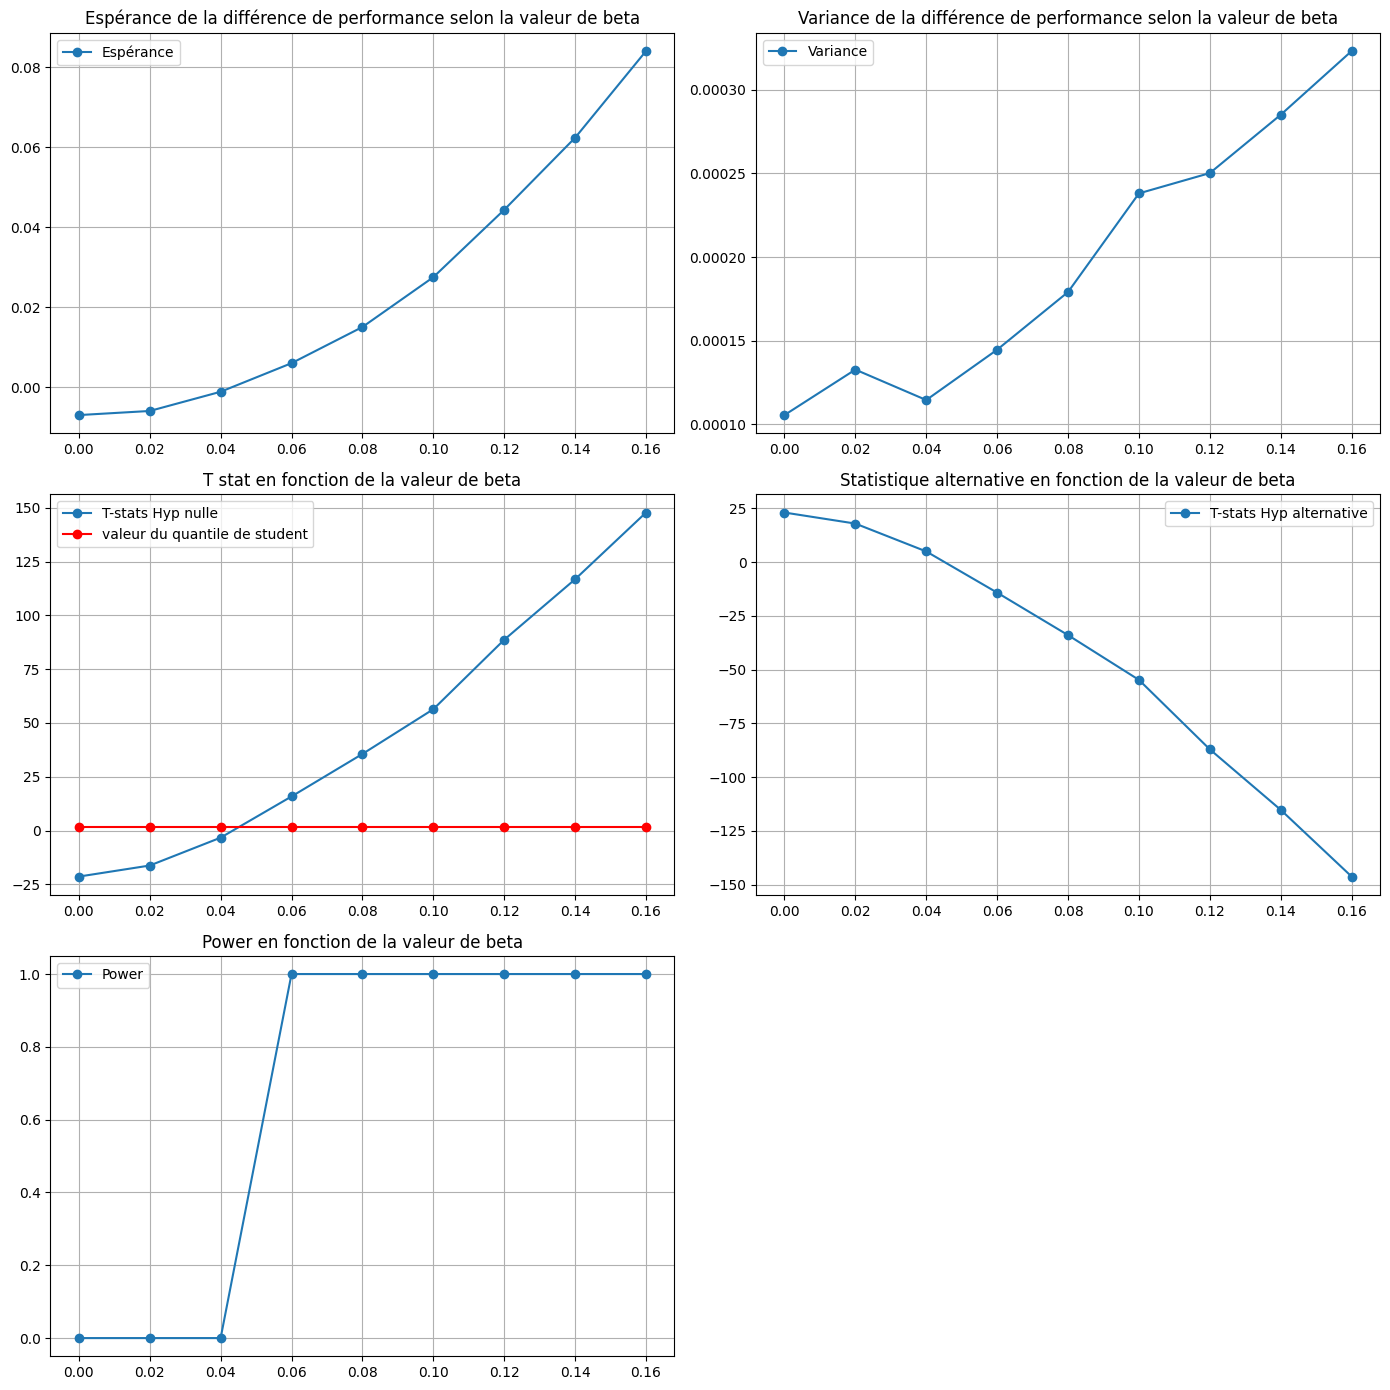

In [26]:
differences, esperances, variances, test_statistics, test_alternative, power = power_simulation(150, 2000, 1000)

beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()

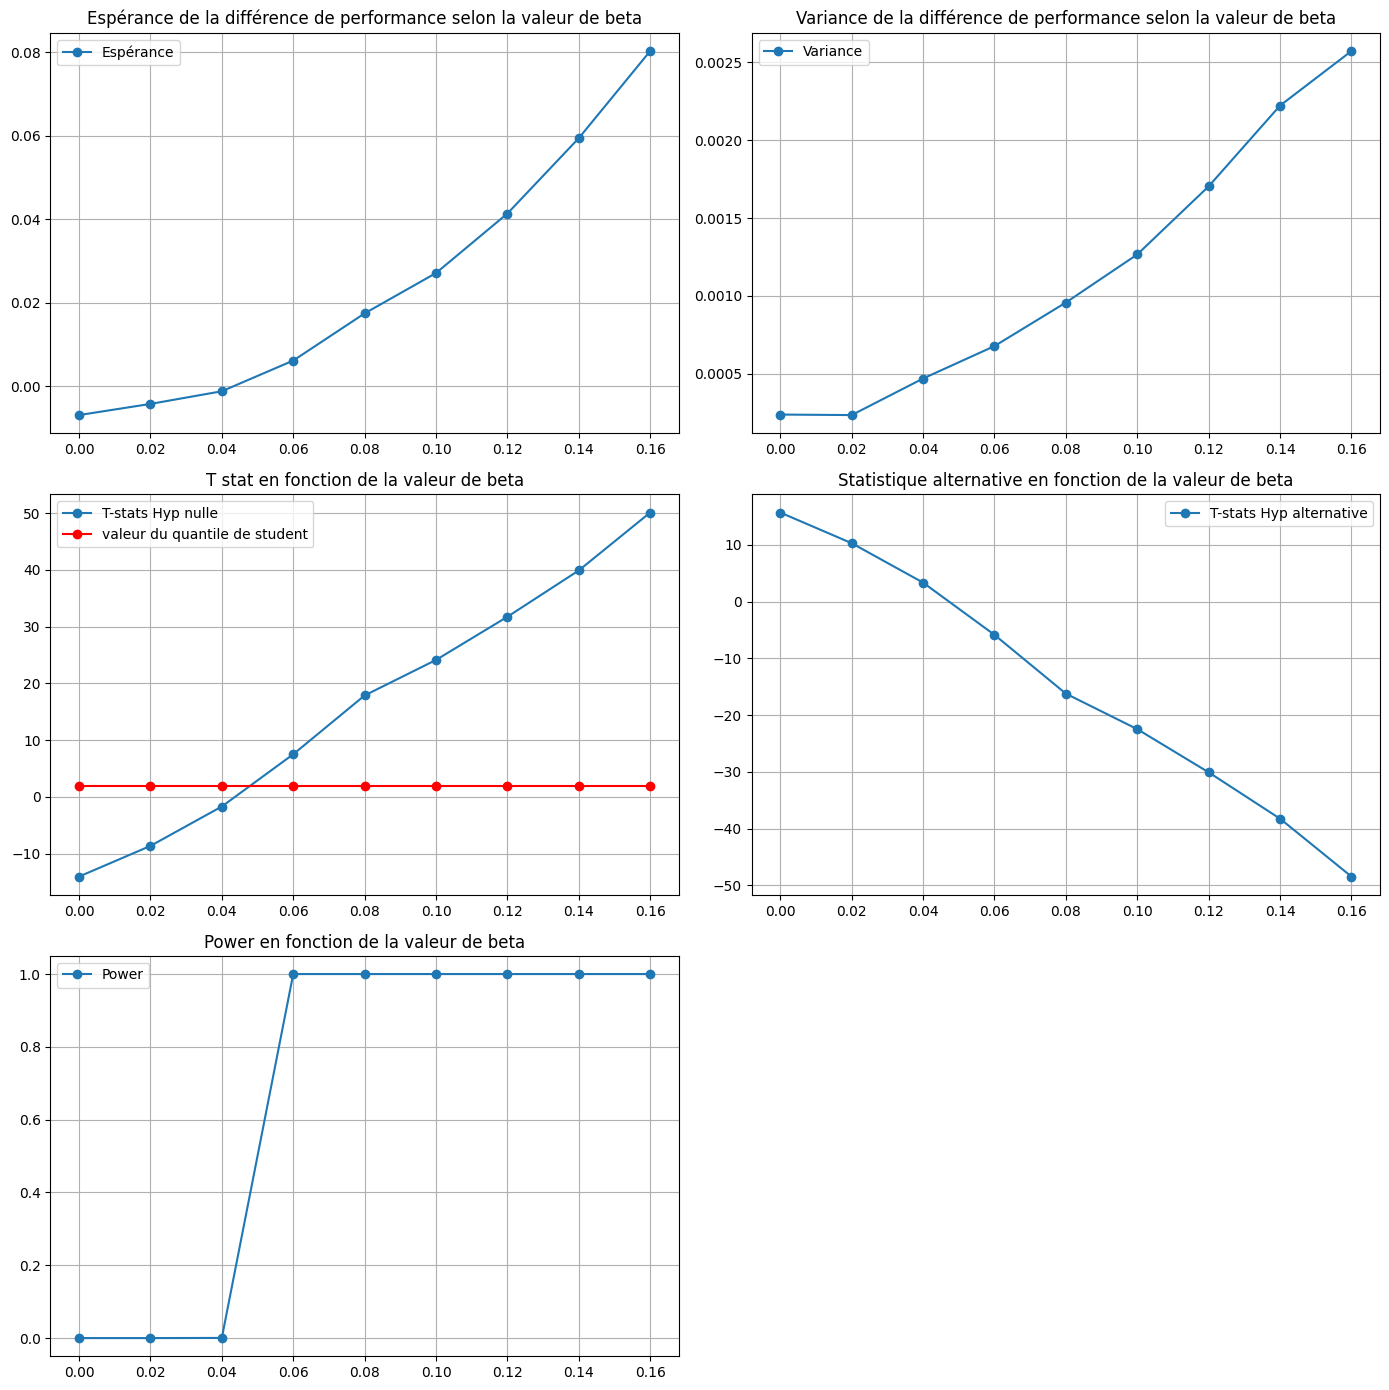

In [27]:
differences150, esperances150, variances150, test_statistics150, test_alternative150, power150 = power_simulation(150, 150, 1000)

beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances150, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances150, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics150, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative150, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power150, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()